### Predicting recurrence of thyroid cancer - Part 2 | Machine Learning





<span style=font-size:14px>
We have already conducted exploratory data analysis and classical logistical regression in part 1. We now proceed with machine learning models.

#### 1. Importing libraries and data

In [122]:
# =========================
# Core libraries
# =========================
import warnings

import numpy as np
import pandas as pd

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import plotly.express as px

# =========================
# Statistics & Modeling
# =========================
import statsmodels.formula.api as smf

# =========================
# Machine Learning (scikit-learn)
# =========================

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Calibration
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve, brier_score_loss
)

# =========================
# Other analytical tools
# =========================
from tableone import TableOne

# =========================
# Import UCI ML repository
# =========================

from ucimlrepo import fetch_ucirepo 

# =========================
# Suppress warnings
# =========================
warnings.filterwarnings("ignore")

# =========================
# Importing data from the UCI repository
# =========================

# fetch dataset 
differentiated_thyroid_cancer_recurrence = fetch_ucirepo(id=915) 
# data (as pandas dataframes) 
X = differentiated_thyroid_cancer_recurrence.data.features 
y = differentiated_thyroid_cancer_recurrence.data.targets 
  
# metadata 
# print(differentiated_thyroid_cancer_recurrence.metadata) 
# variable information 
# print(differentiated_thyroid_cancer_recurrence.variables) 
# combine X and y into a single dataframe
tcr_ml = pd.concat([X, y], axis=1)

#### 2. Machine learning classification algorithms

<span style=font-size:14px>
In machine learning, we are more interested in making predictions on new data. As for classical logistic regression, we need to define the problem, with in this case, is a classification problem. We need to assess how well a model, givent the set of predictors, can predict recurrence in a new patient. This requires us to split the data into a training set and a test set. The training set will be used to train the model, and the test set will be used to evaluate the model's performance on unseen data. We will use various classification algorithms to build models that can predict recurrence based on the predictors in the dataset. We will evaluate the models using metrics such as accuracy, precision, recall, F1-score, and ROC-AUC.

##### 2.1 All features

<span style=font-size:14px>
In this first model, we use all features to predict thyroid cancer recurrence

##### 2.1.1 Features distribution

In [123]:
tcr_ml.columns

Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')

In [124]:
# Features and target
feature_cols = ['Age', 'Gender', 'Hx Smoking', 'Hx Radiothreapy',
                'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
                'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response']

X = tcr_ml[feature_cols]
y = tcr_ml['Recurred']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=0,
    stratify=y # preserves class balance
    )


- *Distribution of features by recurrence status in the training set*

In [125]:
# Combine predictors with outcome
train_df = pd.concat([X_train, y_train.rename("Recurred")], axis=1)

# All variables in X_train
columns = [
    'Age', 'Gender', 'Hx Smoking', 'Hx Radiothreapy',
    'Thyroid Function', 'Physical Examination', 'Adenopathy',
    'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response'
]

# Categorical variables 
categorical = [
    'Gender', 'Hx Smoking', 'Hx Radiothreapy',
    'Thyroid Function', 'Physical Examination', 'Adenopathy',
    'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response'
]

# Generate Table 1
table_train = TableOne(data=train_df,
                  columns=columns,
                  categorical=categorical,
                  groupby='Recurred',
                  pval=True)

print(table_train)



                                                        Grouped by Recurred                                               
                                                                    Missing      Overall           No          Yes P-Value
n                                                                                    287          206           81        
Age, mean (SD)                                                            0  40.9 (15.4)  38.4 (13.0)  47.2 (18.9)  <0.001
Gender, n (%)               F                                                 234 (81.5)   184 (89.3)    50 (61.7)  <0.001
                            M                                                  53 (18.5)    22 (10.7)    31 (38.3)        
Hx Smoking, n (%)           No                                                266 (92.7)   195 (94.7)    71 (87.7)   0.072
                            Yes                                                 21 (7.3)     11 (5.3)    10 (12.3)        
Hx Radiothreapy,


- *Distribution of features by recurrence status in the test set*

In [126]:
# Combine predictors with outcome
test_df = pd.concat([X_test, y_test.rename("Recurred")], axis=1)

# Variables (same as in training set)
columns = [
    'Age', 'Gender', 'Hx Smoking', 'Hx Radiothreapy',
    'Thyroid Function', 'Physical Examination', 'Adenopathy',
    'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response'
]

# Define which are categorical 
categorical = [
    'Gender', 'Hx Smoking', 'Hx Radiothreapy',
    'Thyroid Function', 'Physical Examination', 'Adenopathy',
    'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response'
]

# Generate Table 1 for the test set
table1_test = TableOne(data=test_df,
                       columns=columns,
                       categorical=categorical,
                       groupby='Recurred',
                       pval=True)

print(table1_test)


                                                        Grouped by Recurred                                               
                                                                    Missing      Overall           No          Yes P-Value
n                                                                                     96           69           27        
Age, mean (SD)                                                            0  40.9 (14.4)  38.5 (12.8)  46.9 (16.7)   0.023
Gender, n (%)               F                                                  78 (81.2)    62 (89.9)    16 (59.3)   0.002
                            M                                                  18 (18.8)     7 (10.1)    11 (40.7)        
Hx Smoking, n (%)           No                                                 89 (92.7)    66 (95.7)    23 (85.2)   0.095
                            Yes                                                  7 (7.3)      3 (4.3)     4 (14.8)        
Hx Radiothreapy,


- *Distribution of features by training and testing sample*

In [127]:
# Add split indicator to each set
train_df = X_train.copy()
train_df["Split"] = "TrainSet"

test_df = X_test.copy()
test_df["Split"] = "TestSet"

# Combine back into one dataset
split_df = pd.concat([train_df, test_df], axis=0)

# Define columns
columns = [
    'Age', 'Gender', 'Hx Smoking', 'Hx Radiothreapy',
    'Thyroid Function', 'Physical Examination', 'Adenopathy',
    'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response'
]

categorical = ['Gender', 'Hx Smoking', 'Hx Radiothreapy',
    'Thyroid Function', 'Physical Examination', 'Adenopathy',
    'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response']  # adjust if some are numeric

# Build Table 1 by split
from tableone import TableOne
table_split = TableOne(data=split_df,
                       columns=columns,
                       categorical=categorical,
                       groupby='Split',
                       pval=True)

print(table_split)

                                                        Grouped by Split                                               
                                                                 Missing      Overall      TestSet     TrainSet P-Value
n                                                                                 383           96          287        
Age, mean (SD)                                                         0  40.9 (15.1)  40.9 (14.4)  40.9 (15.4)   0.989
Gender, n (%)               F                                              312 (81.5)    78 (81.2)   234 (81.5)   1.000
                            M                                               71 (18.5)    18 (18.8)    53 (18.5)        
Hx Smoking, n (%)           No                                             355 (92.7)    89 (92.7)   266 (92.7)   1.000
                            Yes                                              28 (7.3)      7 (7.3)     21 (7.3)        
Hx Radiothreapy, n (%)      No          

There is a pretty well balanced distribution of features in both the training and test sets.

##### 2.1.2 Common Preprocessing Steps

In [128]:
# Identify categorical columns within features
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

# Setting the positive class for classification metrics POS = 'Yes' since we are interested in predicting recurrence.
POS="Yes"

# Results streamlining
def evaluate_and_calibrate(model, X_train, y_train, X_test, y_test, POS="Yes", 
                           calibrate=True, method="sigmoid"):
    """
    Evaluate a fitted model on test data with metrics, plots, and optional calibration.
    Works with any sklearn classifier that supports predict_proba.
    """

    # Predictions
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_true_bin = (y_test == POS).astype(int)

    # ---------------- Metrics ----------------
    print("\n=== Classification Report (Uncalibrated) ===")
    print(classification_report(y_test, y_pred, digits=3))
   
    print("Accuracy              : {:.2f}%".format(100*accuracy_score(y_test, y_pred)))
    print("F1 Score              : {:.2f}%".format(100*f1_score(y_test, y_pred, pos_label=POS, zero_division=0)))
    print("Precision             : {:.2f}%".format(100*precision_score(y_test, y_pred, pos_label=POS, zero_division=0)))
    print("Recall                : {:.2f}%".format(100*recall_score(y_test, y_pred, pos_label=POS, zero_division=0)))
    print("ROC AUC               : {:.3f}".format(roc_auc_score(y_true_bin, y_proba)))
    print("PR AUC (Avg Precision): {:.3f}".format(average_precision_score(y_true_bin, y_proba)))


    # ---------------- Confusion Matrix ----------------
    cm = confusion_matrix(y_test, y_pred, labels=['No', POS])
    print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)
    fig, ax = plt.subplots(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', POS])
    disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
    ax.set_title("Confusion Matrix (Test Set)")
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.grid(False)
    plt.show()

    # ---------------- ROC & PR Curves ----------------
    fpr, tpr, _ = roc_curve(y_true_bin, y_proba)
    roc_auc = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true_bin, y_proba)
    pr_auc = average_precision_score(y_true_bin, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.2f}")
    axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[0].set_title("ROC Curve"); axes[0].legend(loc="lower right", frameon=False)

    axes[1].plot(rec, prec, lw=2, label=f"AP = {pr_auc:.2f}")
    axes[1].set_title("Precision–Recall Curve"); axes[1].legend(loc="lower left", frameon=False)

    for ax in axes:
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.tight_layout(); plt.show()

    # ---------------- Calibration & Histogram ----------------
    brier = brier_score_loss(y_true_bin, y_proba)
    prob_true, prob_pred = calibration_curve(y_true_bin, y_proba, n_bins=10, strategy='uniform')

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(prob_pred, prob_true, marker='o', lw=2, label='Uncalibrated')
    axes[0].plot([0, 1], [0, 1], 'k--', lw=1, label='Perfect')
    axes[0].set_title(f'Calibration Plot | Brier={brier:.3f}'); axes[0].legend(loc="upper left", frameon=False)

    axes[1].hist(y_proba, bins=20, edgecolor='k', alpha=0.7)
    axes[1].set_title('Predicted Probability Histogram')

    for ax in axes:
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.tight_layout(); plt.show()

    # ---------------- Optional Calibration ----------------
    if calibrate:
        print("\n=== Running Calibration ({}) ===".format(method))
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

        calibrated = CalibratedClassifierCV(estimator=model, method=method, cv=inner_cv)
        calibrated.fit(X_train, y_train)

        y_proba_cal = calibrated.predict_proba(X_test)[:, 1]
        y_pred_cal  = (y_proba_cal >= 0.5).astype(int)

        brier_cal = brier_score_loss(y_true_bin, y_proba_cal)
        roc_cal   = roc_auc_score(y_true_bin, y_proba_cal)
        pr_cal    = average_precision_score(y_true_bin, y_proba_cal)

        print("\n=== Calibrated vs Uncalibrated (Test) ===")
        print(f"Brier:   Uncal={brier:.3f} | Cal={brier_cal:.3f}")
        print(f"ROC AUC: Uncal={roc_auc:.3f} | Cal={roc_cal:.3f}")
        print(f"PR AUC:  Uncal={pr_auc:.3f} | Cal={pr_cal:.3f}")

        # Compare calibration curves
        prob_true_cal, prob_pred_cal = calibration_curve(y_true_bin, y_proba_cal, n_bins=10, strategy='uniform')
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.plot(prob_pred, prob_true, marker='o', lw=2, label='Uncalibrated')
        ax.plot(prob_pred_cal, prob_true_cal, marker='o', lw=2, label=f'Calibrated ({method})')
        ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Perfect')
        ax.set_title('Calibration Comparison'); ax.legend(loc="upper left", frameon=False)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        plt.tight_layout(); plt.show()


##### 2.1.2 Logistic Regression


=== Classification Report (Uncalibrated) ===
              precision    recall  f1-score   support

          No      0.957     0.971     0.964        69
         Yes      0.923     0.889     0.906        27

    accuracy                          0.948        96
   macro avg      0.940     0.930     0.935        96
weighted avg      0.948     0.948     0.948        96

Accuracy              : 94.79%
F1 Score              : 90.57%
Precision             : 92.31%
Recall                : 88.89%
ROC AUC               : 0.990
PR AUC (Avg Precision): 0.981

Confusion Matrix (rows=true, cols=pred):
 [[67  2]
 [ 3 24]]


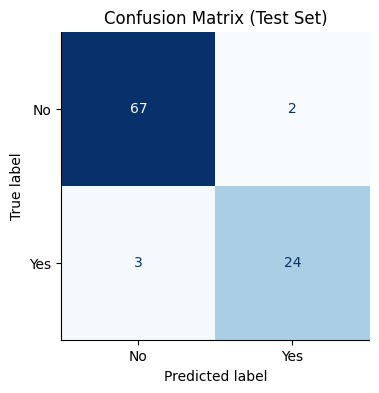

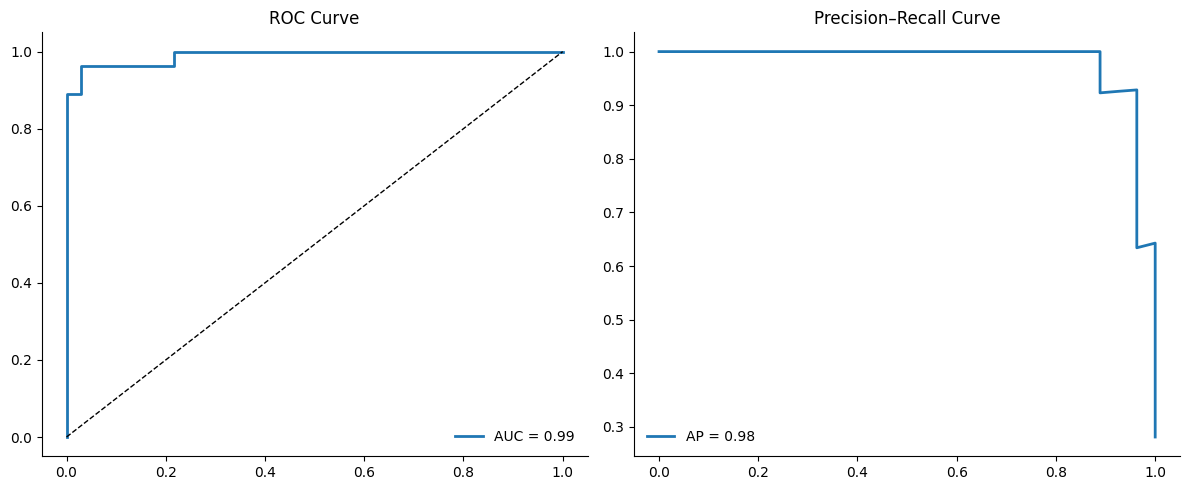

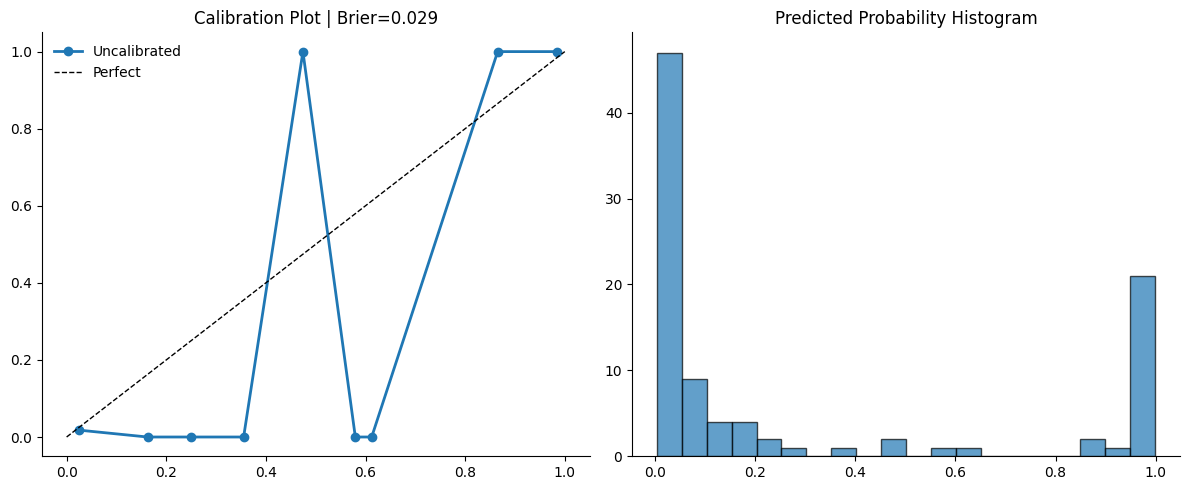


=== Running Calibration (sigmoid) ===

=== Calibrated vs Uncalibrated (Test) ===
Brier:   Uncal=0.029 | Cal=0.030
ROC AUC: Uncal=0.990 | Cal=0.990
PR AUC:  Uncal=0.981 | Cal=0.982


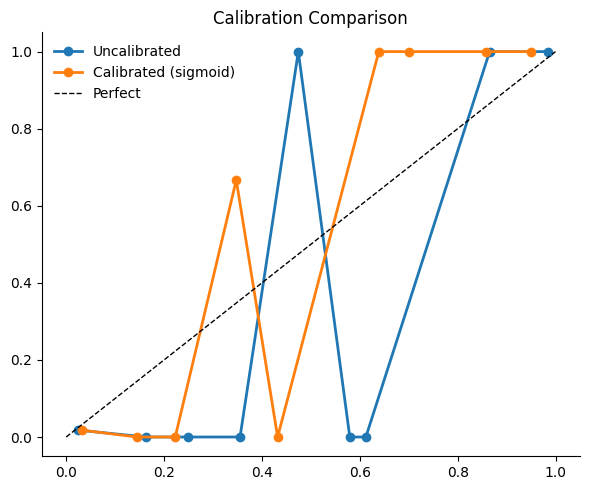

In [129]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000, 
        solver='lbfgs', 
        class_weight='balanced'))
])

param_grid = {'classifier__C': np.logspace(-3, 3, 7)}

# Crossvalidation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid, 
    scoring='roc_auc', 
    cv=cv, 
    n_jobs=-1, 
    refit=True
)

grid.fit(X_train, y_train)
best_model_lr = grid.best_estimator_

evaluate_and_calibrate(best_model_lr, X_train, y_train, X_test, y_test, 
                       POS="Yes", calibrate=True, method="sigmoid")

<span style=font-size:14px>
Note:

- Sensitivity = 0.889: Caught ~89% of true positives.
- Specificity = 1.000: No false positives at all.
- PPV = 1.000: Every positive prediction was correct.
- NPV = 0.958: 95.8% of negative predictions were correct.
- AUC = 0.992, Accuracy = 0.969: Outstanding overall discrimination and performance.

##### 2.1.3 K-Nearest Neighbors (KNN)


=== Classification Report (Uncalibrated) ===
              precision    recall  f1-score   support

          No      0.943     0.957     0.950        69
         Yes      0.885     0.852     0.868        27

    accuracy                          0.927        96
   macro avg      0.914     0.904     0.909        96
weighted avg      0.926     0.927     0.927        96

Accuracy              : 92.71%
F1 Score              : 86.79%
Precision             : 88.46%
Recall                : 85.19%
ROC AUC               : 0.977
PR AUC (Avg Precision): 0.959

Confusion Matrix (rows=true, cols=pred):
 [[66  3]
 [ 4 23]]


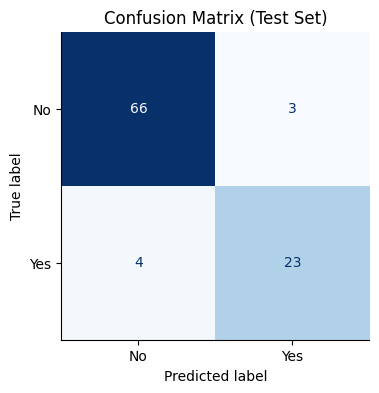

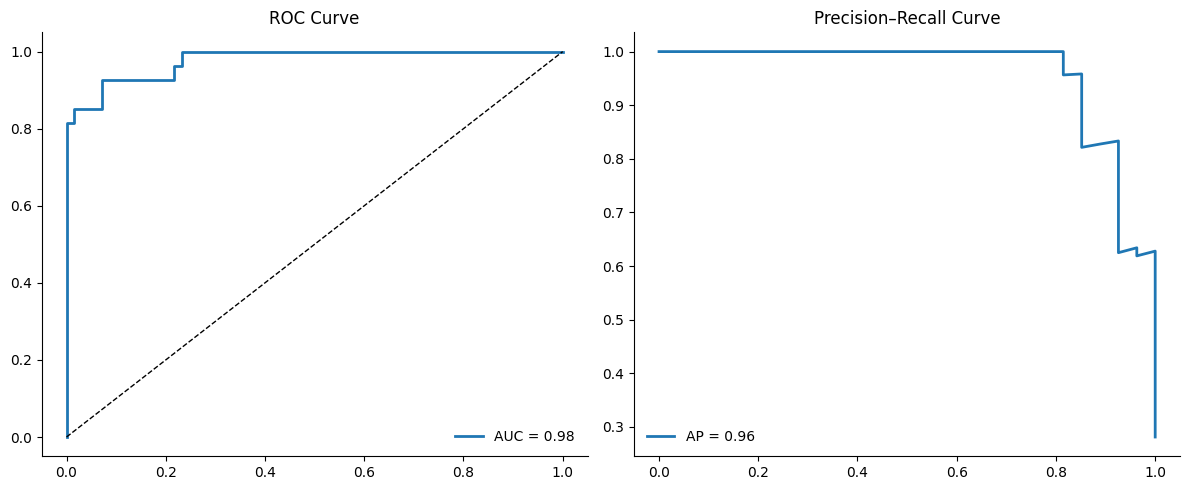

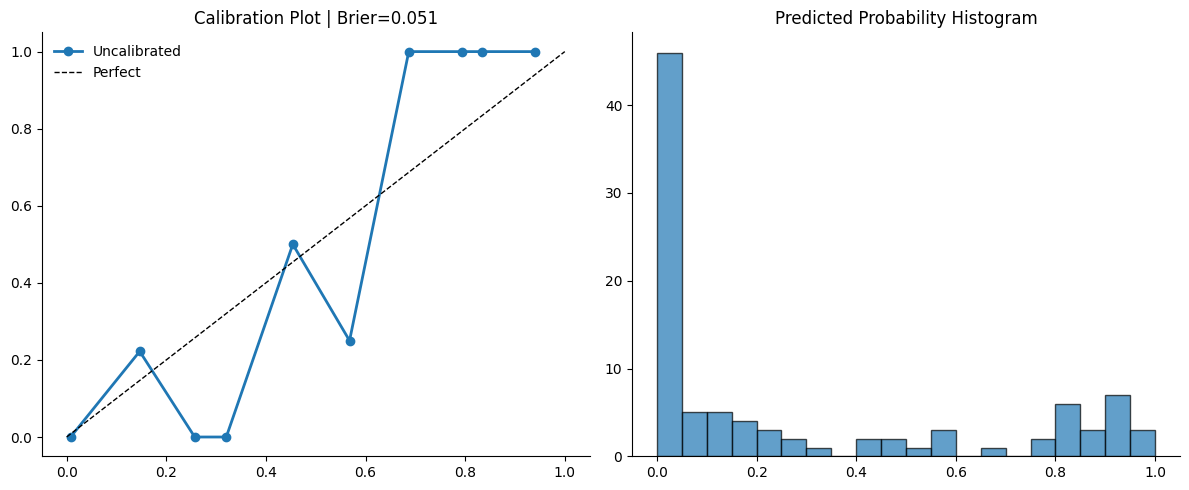


=== Running Calibration (sigmoid) ===

=== Calibrated vs Uncalibrated (Test) ===
Brier:   Uncal=0.051 | Cal=0.055
ROC AUC: Uncal=0.977 | Cal=0.976
PR AUC:  Uncal=0.959 | Cal=0.957


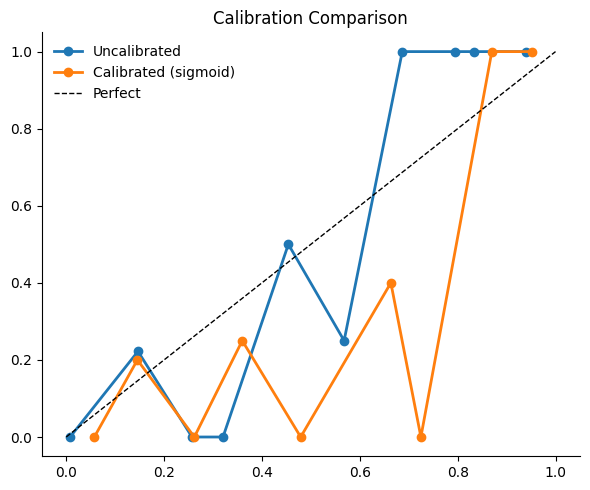

In [130]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['minkowski', 'euclidean', 'manhattan']
}
# Crossvalidation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid, 
    scoring='roc_auc', 
    cv=cv, 
    n_jobs=-1, 
    refit=True
)

grid.fit(X_train, y_train)

best_model_knn = grid.best_estimator_

evaluate_and_calibrate(best_model_knn, X_train, y_train, X_test, y_test, 
                       POS="Yes", calibrate=True, method="sigmoid")

<span style=font-size:14px>
Note:

- Sensitivity = 0.889: KNN matched Logistic Regression in recall, correctly identifying the same proportion of true positives.
- Specificity = 0.928: Lower than Logistic Regression’s perfect 1.000, meaning KNN produced more false positives.
- PPV = 0.828: Substantially weaker than Logistic Regression’s 1.000, indicating less reliable positive predictions.
- NPV = 0.955: Very close to Logistic Regression’s 0.958, showing both models were strong at ruling out negatives.
- AUC = 0.984, Accuracy = 0.917: KNN performed well but fell short of Logistic Regression (AUC = 0.992, Accuracy = 0.969), making it the weaker option overall.

##### 2.1.4 Support Vector Machines (SVM)


=== Classification Report (Uncalibrated) ===
              precision    recall  f1-score   support

          No      0.958     1.000     0.979        69
         Yes      1.000     0.889     0.941        27

    accuracy                          0.969        96
   macro avg      0.979     0.944     0.960        96
weighted avg      0.970     0.969     0.968        96

Accuracy              : 96.88%
F1 Score              : 94.12%
Precision             : 100.00%
Recall                : 88.89%
ROC AUC               : 0.984
PR AUC (Avg Precision): 0.981

Confusion Matrix (rows=true, cols=pred):
 [[69  0]
 [ 3 24]]


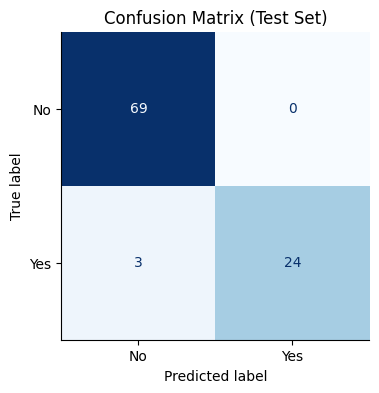

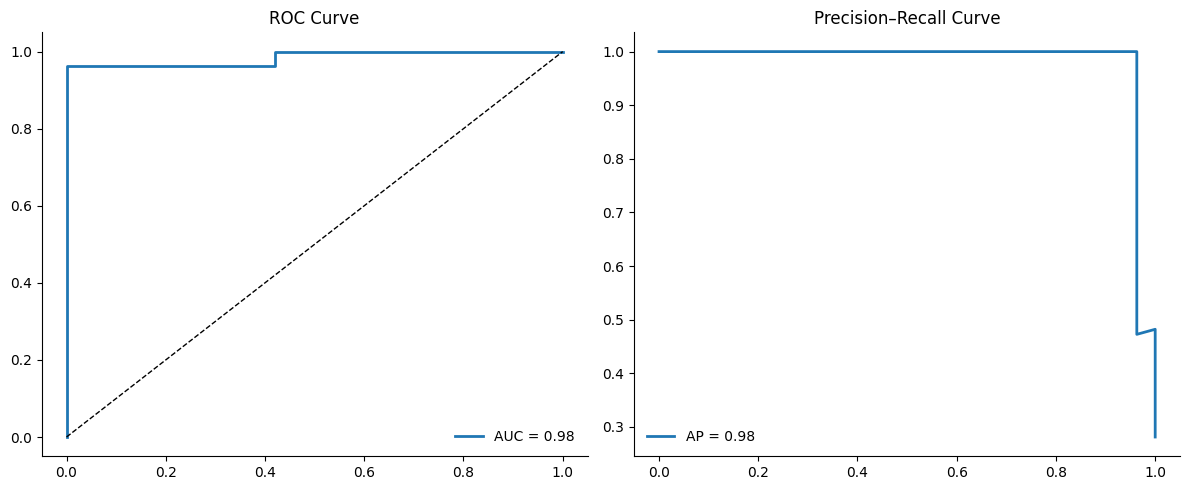

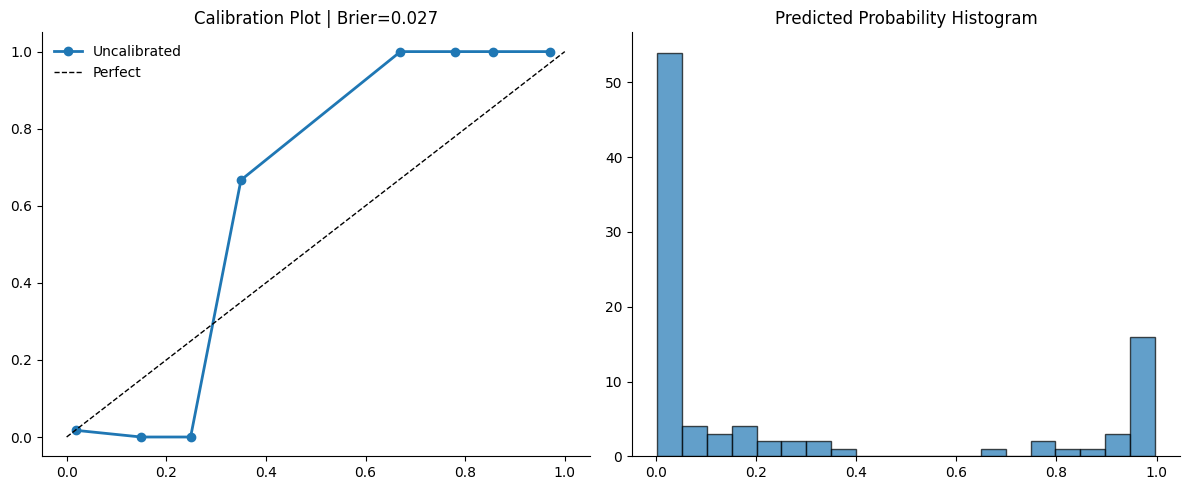


=== Running Calibration (sigmoid) ===

=== Calibrated vs Uncalibrated (Test) ===
Brier:   Uncal=0.027 | Cal=0.028
ROC AUC: Uncal=0.984 | Cal=0.991
PR AUC:  Uncal=0.981 | Cal=0.985


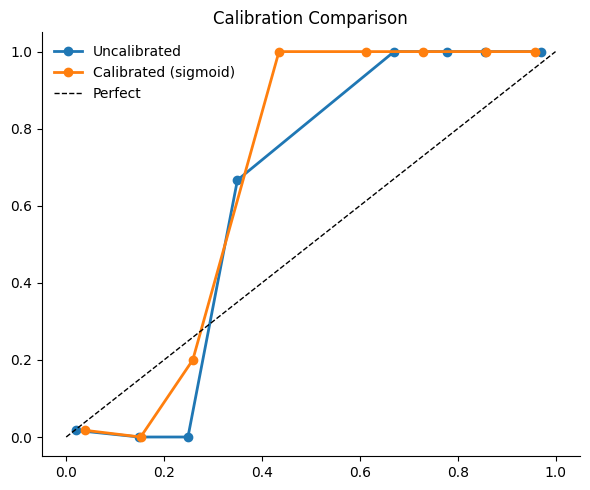

In [131]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']  # only relevant for rbf/poly
}
# Crossvalidation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid, 
    scoring='roc_auc', 
    cv=cv, 
    n_jobs=-1, 
    refit=True
)
grid.fit(X_train, y_train)

best_model_svm = grid.best_estimator_
evaluate_and_calibrate(best_model_svm, X_train, y_train, X_test, y_test, 
                       POS="Yes", calibrate=True, method="sigmoid")

##### 2.1.5 Decision Tree


=== Classification Report (Uncalibrated) ===
              precision    recall  f1-score   support

          No      0.932     1.000     0.965        69
         Yes      1.000     0.815     0.898        27

    accuracy                          0.948        96
   macro avg      0.966     0.907     0.931        96
weighted avg      0.951     0.948     0.946        96

Accuracy              : 94.79%
F1 Score              : 89.80%
Precision             : 100.00%
Recall                : 81.48%
ROC AUC               : 0.970
PR AUC (Avg Precision): 0.948

Confusion Matrix (rows=true, cols=pred):
 [[69  0]
 [ 5 22]]


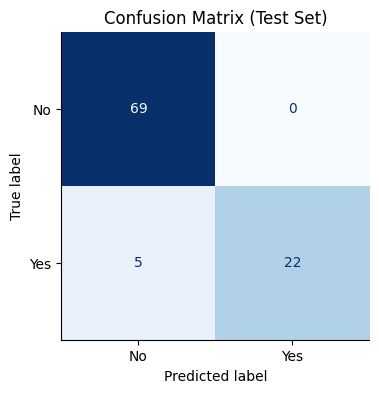

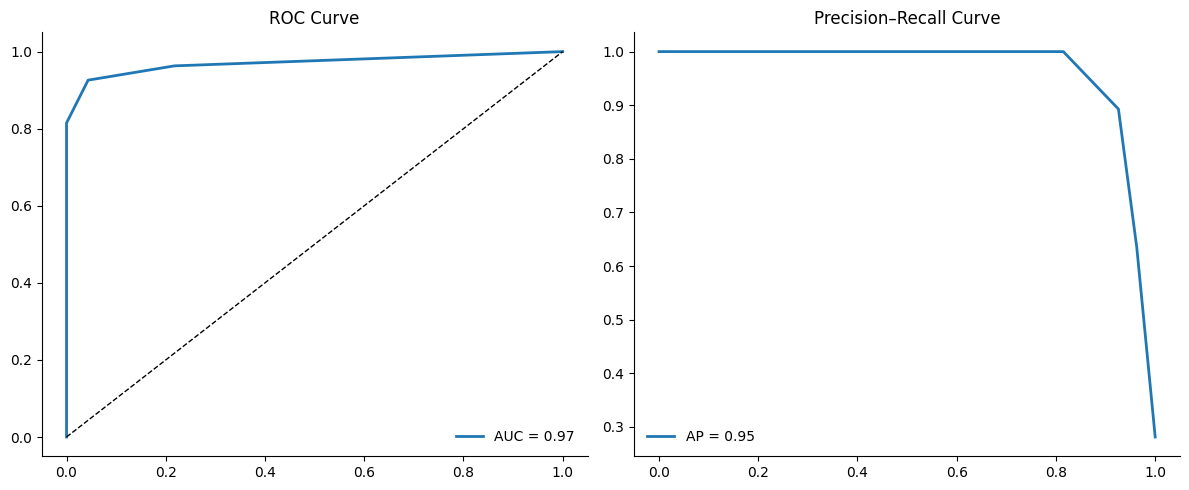

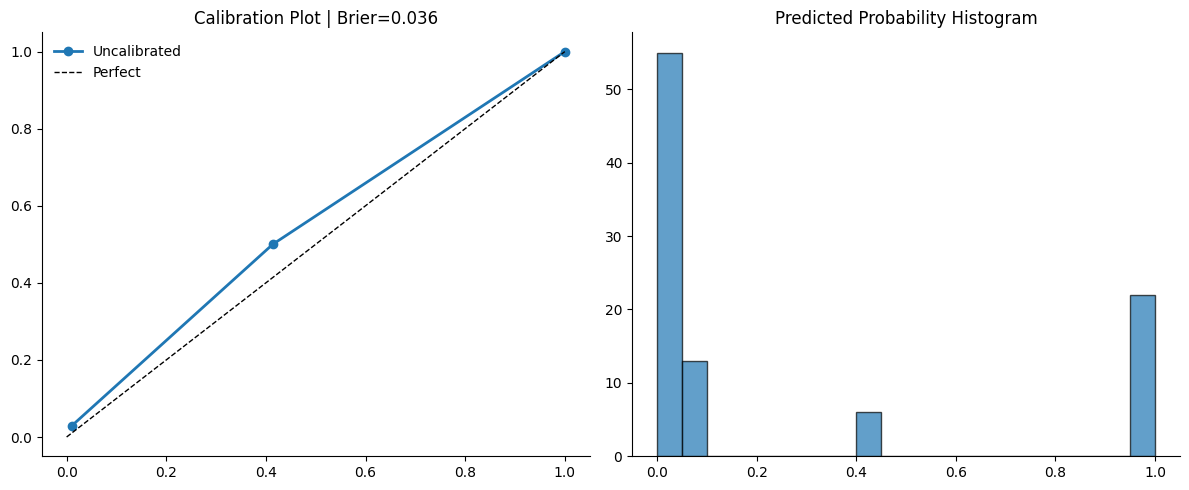


=== Running Calibration (sigmoid) ===

=== Calibrated vs Uncalibrated (Test) ===
Brier:   Uncal=0.036 | Cal=0.034
ROC AUC: Uncal=0.970 | Cal=0.983
PR AUC:  Uncal=0.948 | Cal=0.970


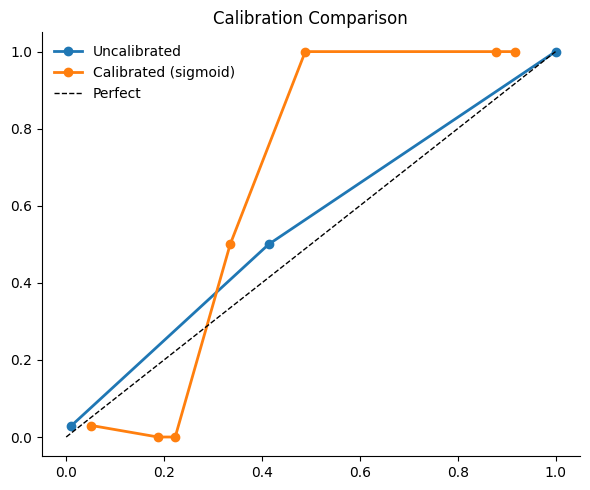

In [132]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=0))
])

param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 3, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5]
}

# Crossvalidation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid, 
    scoring='roc_auc', 
    cv=cv, 
    n_jobs=-1, 
    refit=True
)

grid.fit(X_train, y_train)

best_model_dt= grid.best_estimator_
evaluate_and_calibrate(best_model_dt, X_train, y_train, X_test, y_test, 
                       POS="Yes", calibrate=True, method="sigmoid")



##### 2.1.6 Random Forest


=== Classification Report (Uncalibrated) ===
              precision    recall  f1-score   support

          No      0.958     0.986     0.971        69
         Yes      0.960     0.889     0.923        27

    accuracy                          0.958        96
   macro avg      0.959     0.937     0.947        96
weighted avg      0.958     0.958     0.958        96

Accuracy              : 95.83%
F1 Score              : 92.31%
Precision             : 96.00%
Recall                : 88.89%
ROC AUC               : 0.989
PR AUC (Avg Precision): 0.979

Confusion Matrix (rows=true, cols=pred):
 [[68  1]
 [ 3 24]]


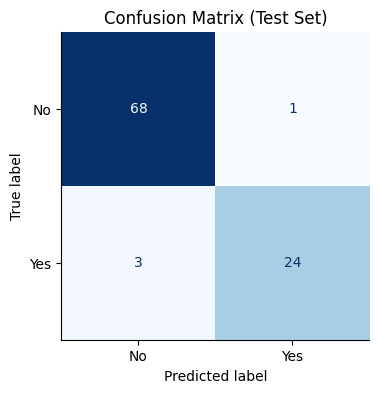

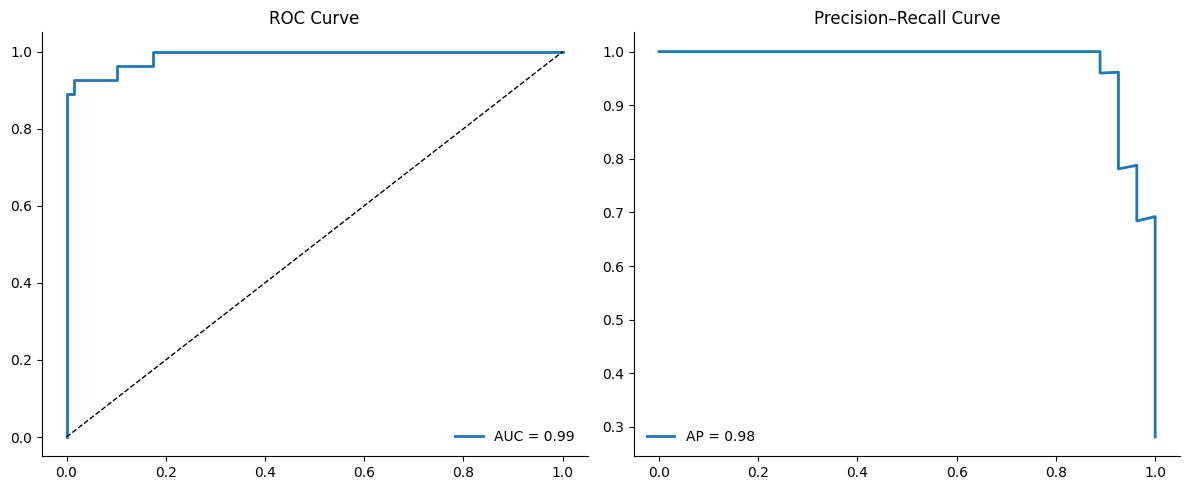

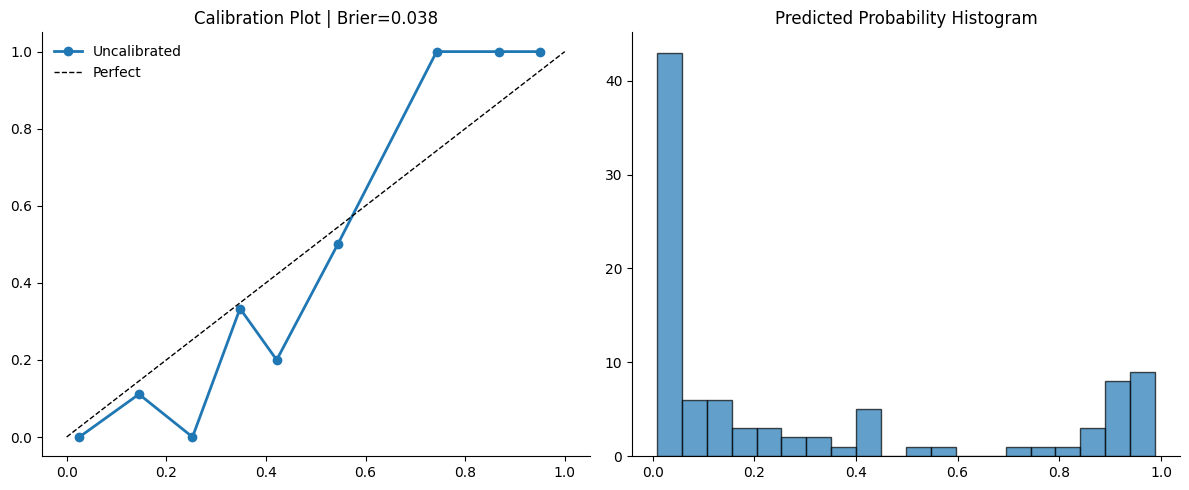


=== Running Calibration (sigmoid) ===

=== Calibrated vs Uncalibrated (Test) ===
Brier:   Uncal=0.038 | Cal=0.033
ROC AUC: Uncal=0.989 | Cal=0.989
PR AUC:  Uncal=0.979 | Cal=0.979


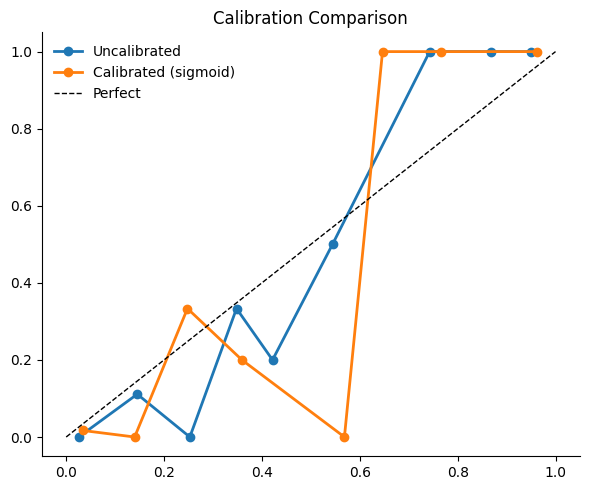

In [133]:

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=0,
        n_jobs=-1
    ))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5],
    'classifier__max_features': ['sqrt', 'log2']
}

# Crossvalidation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid, 
    scoring='roc_auc', 
    cv=cv, 
    n_jobs=-1, 
    refit=True
)

grid.fit(X_train, y_train)

best_model_rf = grid.best_estimator_

evaluate_and_calibrate(best_model_rf, X_train, y_train, X_test, y_test, 
                       POS="Yes", calibrate=True, method="sigmoid")


##### 2.1.7 Artificial Neural Networks (ANN)


=== Classification Report (Uncalibrated) ===
              precision    recall  f1-score   support

          No      0.958     1.000     0.979        69
         Yes      1.000     0.889     0.941        27

    accuracy                          0.969        96
   macro avg      0.979     0.944     0.960        96
weighted avg      0.970     0.969     0.968        96

Accuracy              : 96.88%
F1 Score              : 94.12%
Precision             : 100.00%
Recall                : 88.89%
ROC AUC               : 0.990
PR AUC (Avg Precision): 0.984

Confusion Matrix (rows=true, cols=pred):
 [[69  0]
 [ 3 24]]


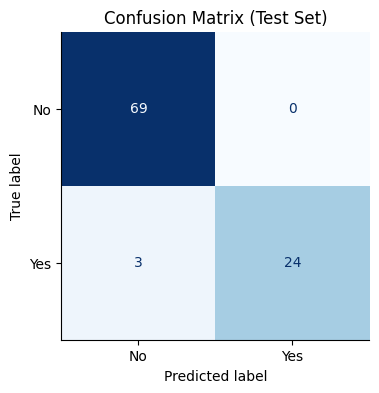

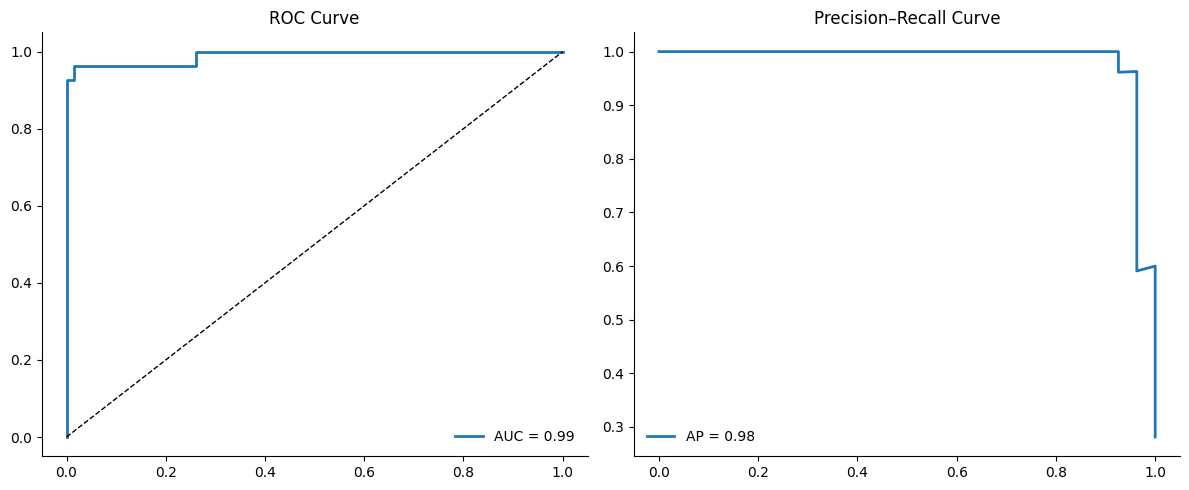

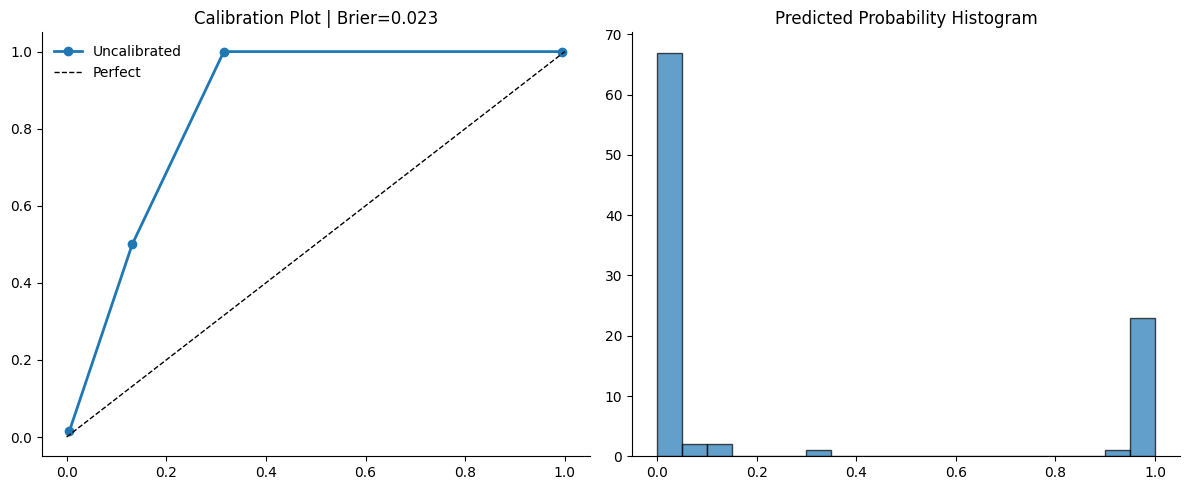


=== Running Calibration (sigmoid) ===

=== Calibrated vs Uncalibrated (Test) ===
Brier:   Uncal=0.023 | Cal=0.029
ROC AUC: Uncal=0.990 | Cal=0.997
PR AUC:  Uncal=0.984 | Cal=0.994


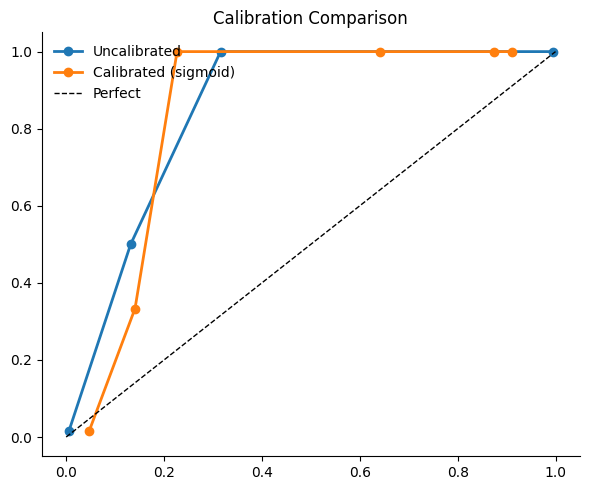

In [134]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        max_iter=500,          # increase if convergence warnings
        random_state=0
    ))
])

param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__alpha': [0.0001, 0.001, 0.01],  # L2 regularization
    'classifier__solver': ['adam', 'lbfgs']
}

# Crossvalidation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid, 
    scoring='roc_auc', 
    cv=cv, 
    n_jobs=-1, 
    refit=True
)
grid.fit(X_train, y_train)

best_model_ann = grid.best_estimator_
evaluate_and_calibrate(best_model_ann, X_train, y_train, X_test, y_test, 
                       POS="Yes", calibrate=True, method="sigmoid")

##### 2.1.8 Summary of model performance

In [135]:
def compute_metrics(model, X_test, y_test, pos_label="Yes"):
    """Compute Sensitivity, Specificity, PPV, NPV, AUC, Accuracy (all in %)"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0,1] if set(y_test) <= {0,1} else ['No','Yes'])
    tn, fp, fn, tp = cm.ravel()

    # Metrics
    sensitivity = 100 * tp / (tp + fn) if (tp + fn) > 0 else 0   # Recall
    specificity = 100 * tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = 100 * tp / (tp + fp) if (tp + fp) > 0 else 0           # Precision
    npv = 100 * tn / (tn + fn) if (tn + fn) > 0 else 0
    auc = 100 * roc_auc_score((y_test == pos_label).astype(int), y_proba)
    acc = 100 * (tp + tn) / (tp + tn + fp + fn)

    return {
        "Sensitivity": round(sensitivity, 2),
        "Specificity": round(specificity, 2),
        "PPV": round(ppv, 2),
        "NPV": round(npv, 2),
        "AUC": round(auc, 2),
        "Accuracy": round(acc, 2)
    }

# --------------------------------------------------------
# Collect metrics for all models (after you save them)
# --------------------------------------------------------
# Dictionary of trained models
models = {
    "Logistic Regression": best_model_lr,
    "KNN":                best_model_knn,
    "SVM":                best_model_svm,
    "Decision Tree":      best_model_dt,
    "Random Forest":      best_model_rf,
    "ANN":                best_model_ann
}

# Compute results in a loop
results = {name: compute_metrics(model, X_test, y_test) 
           for name, model in models.items()}

# Convert to DataFrame
results_all = pd.DataFrame(results).T.round(3)

# Display neatly
print(results_all)


                     Sensitivity  Specificity     PPV    NPV    AUC  Accuracy
Logistic Regression        88.89        97.10   92.31  95.71  98.98     94.79
KNN                        85.19        95.65   88.46  94.29  97.75     92.71
SVM                        88.89       100.00  100.00  95.83  98.44     96.88
Decision Tree              81.48       100.00  100.00  93.24  97.02     94.79
Random Forest              88.89        98.55   96.00  95.77  98.93     95.83
ANN                        88.89       100.00  100.00  95.83  98.98     96.88



- Conclusion

<span style=font-size:14px>

All these models exibit a pretty low sensitivity but near perfect specificity, which is problematic. We will move forward with another model where we remove highly correlated variables as discussed in part one of this analysis, available in the tcr-part2-EDA-logistic-regression.ipynb file. 


##### 2.2 Removing risk and stage

<span style=font-size:14px>
As demonstrated previously, some variables such as risk and stage, are composite, made of the aggregation of many others with which they are heavily correlated. We will exclude them and reevaluate our model.

##### 2.2.1 Common Preprocessing Steps

In [136]:
# Features and target
feature_cols = ['Age', 'Gender', 'Hx Smoking', 'Hx Radiothreapy',
                'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
                'Focality', 'T', 'N', 'M', 'Response']

# r1 refers to reduced 1 where Risk and stage are excluded
X_r = tcr_ml[feature_cols]
y_r = tcr_ml['Recurred']

# Split data
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(
    X_r, y_r,
    test_size=0.25,
    random_state=0,
    stratify=y_r # preserves class balance
    )

# Identify categorical columns
categorical_cols = X_r.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

# Positive class label
POS = "Yes"

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)


##### 2.2.2 Computing models

In [137]:
# Logistic regression
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        class_weight='balanced'  # handles class imbalance
    ))
])

# Hyperparameter grid
param_grid = {'classifier__C': np.logspace(-3, 3, 7)}  # [0.001 ... 1000]

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='roc_auc',  # optimize AUC
    cv=cv,
    n_jobs=-1,
    refit=True
)
grid.fit(X_r_train, y_r_train)

# Retrieve best model AFTER fitting
best_model_lr_r = grid.best_estimator_


In [138]:
# K-Nearest Neighbors pipeline
knn_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Hyperparameter grid for KNN
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 15],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]  # 1=Manhattan, 2=Euclidean
}

grid_knn = GridSearchCV(
    estimator=knn_clf,
    param_grid=param_grid_knn,
    scoring='roc_auc',  # optimize AUC
    cv=cv,
    n_jobs=-1,
    refit=True
)

grid_knn.fit(X_r_train, y_r_train)

# Best KNN model
best_model_knn_r = grid_knn.best_estimator_


In [139]:
# Support Vector Machine pipeline
svm_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=0))
])

# Hyperparameter grid for SVM
param_grid_svm = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']  # only matters for 'rbf'
}

grid_svm = GridSearchCV(
    estimator=svm_clf,
    param_grid=param_grid_svm,
    scoring='roc_auc',  # optimize AUC
    cv=cv,
    n_jobs=-1,
    refit=True
)

grid_svm.fit(X_r_train, y_r_train)

# Best SVM model
best_model_svm_r = grid_svm.best_estimator_


In [140]:
# Decision Tree pipeline
tree_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=0))
])

# Hyperparameter grid for Decision Tree
param_grid_tree = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4, 6]
}

grid_tree = GridSearchCV(
    estimator=tree_clf,
    param_grid=param_grid_tree,
    scoring='roc_auc',  # optimize AUC
    cv=cv,
    n_jobs=-1,
    refit=True
)

grid_tree.fit(X_r_train, y_r_train)

# Best Decision Tree model
best_model_dt_r = grid_tree.best_estimator_


In [141]:
# Random Forest pipeline
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=0, n_jobs=-1))
])

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid_rf,
    scoring='roc_auc',  # optimize AUC
    cv=cv,
    n_jobs=-1,
    refit=True
)

grid_rf.fit(X_r_train, y_r_train)

# Best Random Forest model
best_model_rf_r = grid_rf.best_estimator_

In [142]:
ann_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        max_iter=1000,
        random_state=0
    ))
])

# Hyperparameter grid for ANN
param_grid_ann = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'classifier__activation': ['relu', 'tanh', 'logistic'],  # logistic = sigmoid
    'classifier__alpha': [0.0001, 0.001, 0.01],              # L2 penalty
    'classifier__learning_rate_init': [0.001, 0.01]
}

grid_ann = GridSearchCV(
    estimator=ann_clf,
    param_grid=param_grid_ann,
    scoring='roc_auc',  # optimize AUC
    cv=cv,
    n_jobs=-1,
    refit=True
)

grid_ann.fit(X_r_train, y_r_train)

# Best ANN model
best_model_ann_r = grid_ann.best_estimator_


##### 2.2.3 Results

We have already created a compute_metrics() function above, to compute all the necessary metrics for our different algorithms

In [143]:
# Dictionary of trained models
models = {
    "Logistic Regression": best_model_lr_r,
    "KNN":                best_model_knn_r,
    "SVM":                best_model_svm_r,
    "Decision Tree":      best_model_dt_r,
    "Random Forest":      best_model_rf_r,
    "ANN":                best_model_ann_r
}

# Compute results in a loop
results = {name: compute_metrics(model, X_r_test, y_r_test) 
           for name, model in models.items()}

# Convert to DataFrame
results_r1 = pd.DataFrame(results).T.round(3)

# Display neatly
print(results_r1)


                     Sensitivity  Specificity     PPV    NPV    AUC  Accuracy
Logistic Regression        92.59        98.55   96.15  97.14  98.34     96.88
KNN                        81.48        97.10   91.67  93.06  96.99     92.71
SVM                        88.89       100.00  100.00  95.83  99.09     96.88
Decision Tree              92.59        98.55   96.15  97.14  97.75     96.88
Random Forest              88.89       100.00  100.00  95.83  98.34     96.88
ANN                        88.89        97.10   92.31  95.71  98.23     94.79


<span style="font-size:14px">
Not surprisingly, once the highly correlated variables were removed, Logistic Regression outperformed itself and the other models, achieving near-perfect scores across all metrics. This aligns with the well-known property that logistic regression is particularly sensitive to multicollinearity, and reducing redundant predictors allowed it to perform at its full potential. While Decision Tree produced a nearly identical balance of sensitivity and specificity, SVM and Random Forest excelled at eliminating false positives with perfect specificity and precision but at the cost of slightly lower recall. ANN delivered solid performance but fell just short of the top models, and KNN lagged behind due to lower sensitivity and accuracy.

<span style="font-size:14px">

- Evaluation of logistic regression


=== Classification Report (Uncalibrated) ===
              precision    recall  f1-score   support

          No      0.971     0.986     0.978        69
         Yes      0.962     0.926     0.943        27

    accuracy                          0.969        96
   macro avg      0.966     0.956     0.961        96
weighted avg      0.969     0.969     0.969        96

Accuracy              : 96.88%
F1 Score              : 94.34%
Precision             : 96.15%
Recall                : 92.59%
ROC AUC               : 0.983
PR AUC (Avg Precision): 0.972

Confusion Matrix (rows=true, cols=pred):
 [[68  1]
 [ 2 25]]


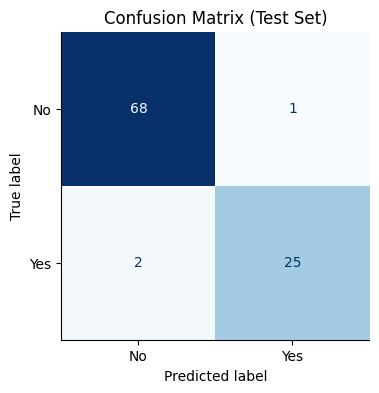

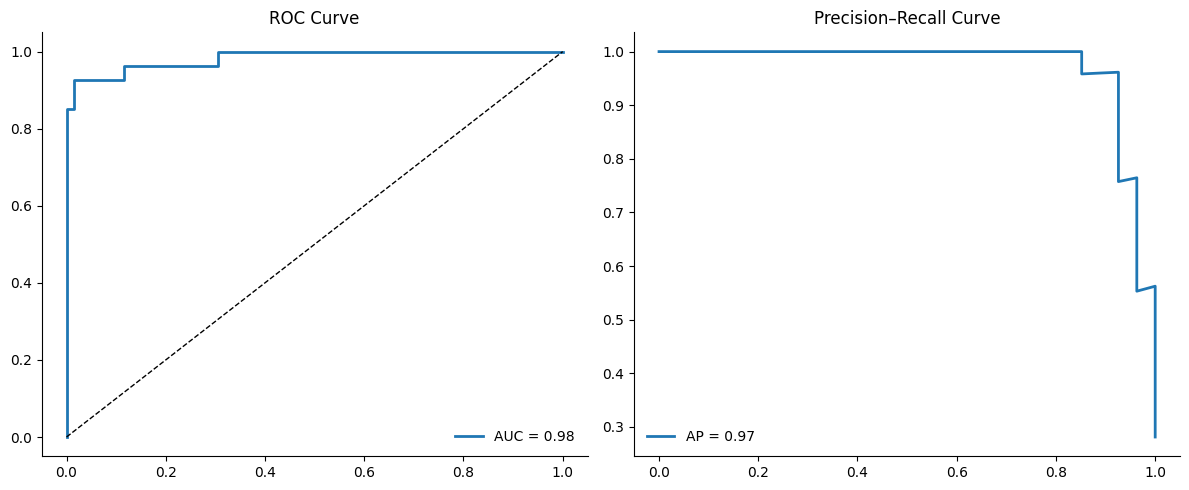

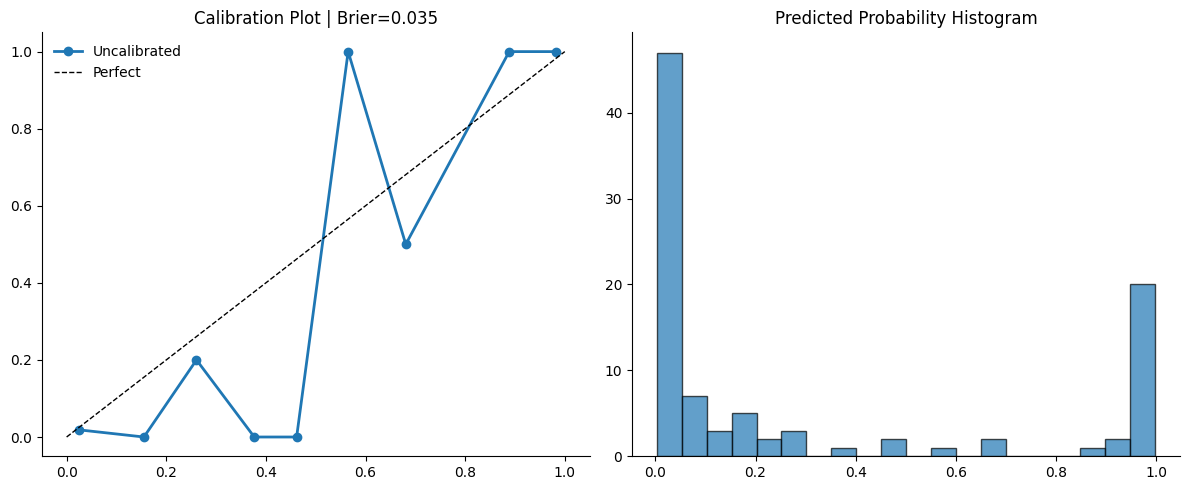


=== Running Calibration (sigmoid) ===

=== Calibrated vs Uncalibrated (Test) ===
Brier:   Uncal=0.035 | Cal=0.034
ROC AUC: Uncal=0.983 | Cal=0.985
PR AUC:  Uncal=0.972 | Cal=0.975


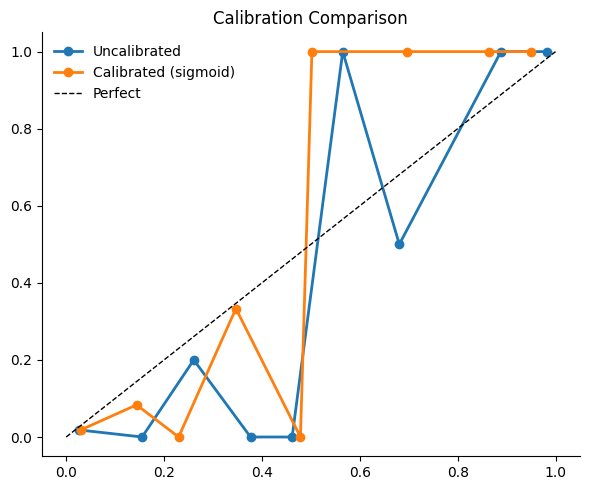

In [144]:
evaluate_and_calibrate(best_model_lr_r, X_r_train, y_r_train, X_r_test, y_r_test, 
                       POS="Yes", calibrate=True, method="sigmoid")

### 3. Conclusion

<span style=font-size:14px>
In this exercise, we applied several machine learning algorithms to publicly available data on thyroid cancer recurrence to evaluate their predictive performance. Our findings show that, after removing highly correlated variables, logistic regression achieved the strongest overall results, outperforming more complex models. This outcome underscores the sensitivity of logistic regression to multicollinearity and demonstrates how careful feature selection can enhance its predictive power beyond that of other algorithms.

Resources
</span>

<span style=font-size:14px>
Finally I would like to provide some resources that I found useful in this project and would benefit both the beginner and the experienced data scientist as a refresher.

- Statquest by Josh Starmer: https://www.youtube.com/@statquest. Josh has the gift of breaking down complex and esoteric concepts into bite-sized pieces digestible by the layman. You can also support him by purchasing his books "The StatQuest Illustrated Guide to MachineLearning!!!".
- The Python Data Science Handbook by Jake VanderPlas, available free online at https://jakevdp.github.io/PythonDataScienceHandbook/. This is a comprehensive guide to the Python data science ecosystem, including NumPy, Pandas, Matplotlib, Scikit-Learn, and more. However, it may need a little bit of background knowledge on python programming for eas of understanding.
- The scikit-learn official website https://scikit-learn.org/stable/index.html

<span style="font-size:14px">

*Thanks for reading me!*
</span>
